# HR Analytics: Predicting Employee Churn with a Decision Tree

In [20]:
# Modules needed
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Seaborn parameters for visualization
sns.set(rc={"figure.figsize":(10, 5)})
sns.set_context("notebook")
sns.set_style("white")

In [52]:
# Import data
url = "https://assets.datacamp.com/production/repositories/1765/datasets/ae888d00f9b36dd7d50a4afbc112761e2db766d2/turnover.csv"

data = pd.read_csv(url)

display(data.head())
display(data.shape)

,satisfaction,evaluation,number_of_projects,average_montly_hours,time_spend_company,work_accident,churn,promotion,department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


(14999, 10)

## Data Validation

In [22]:
# Check data types
data.dtypes

satisfaction            float64
evaluation              float64
number_of_projects        int64
average_montly_hours      int64
time_spend_company        int64
work_accident             int64
churn                     int64
promotion                 int64
department               object
salary                   object
dtype: object

In [23]:
# Check missing values
data.isnull().sum()

satisfaction            0
evaluation              0
number_of_projects      0
average_montly_hours    0
time_spend_company      0
work_accident           0
churn                   0
promotion               0
department              0
salary                  0
dtype: int64

In [24]:
# Identify columns with binary values
for x in data.columns:
    print(x, len(data[x].unique()))

satisfaction 92
evaluation 65
number_of_projects 6
average_montly_hours 215
time_spend_company 8
work_accident 2
churn 2
promotion 2
department 10
salary 3


## Exploratory Data Analysis

In [25]:
# Summary statistics for non-binary numeric variables
data.drop(["work_accident", "churn", "promotion"], axis=1).describe()

,satisfaction,evaluation,number_of_projects,average_montly_hours,time_spend_company
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,0.612834,0.716102,3.803054,201.050337,3.498233
std,0.248631,0.171169,1.232592,49.943099,1.460136
min,0.090000,0.360000,2.000000,96.000000,2.000000
25%,0.440000,0.560000,3.000000,156.000000,3.000000
50%,0.640000,0.720000,4.000000,200.000000,3.000000
75%,0.820000,0.870000,5.000000,245.000000,4.000000
max,1.000000,1.000000,7.000000,310.000000,10.000000


In [26]:
# Churn proportion
data.churn.value_counts(normalize=True).round(2)

0    0.76
1    0.24
Name: churn, dtype: float64

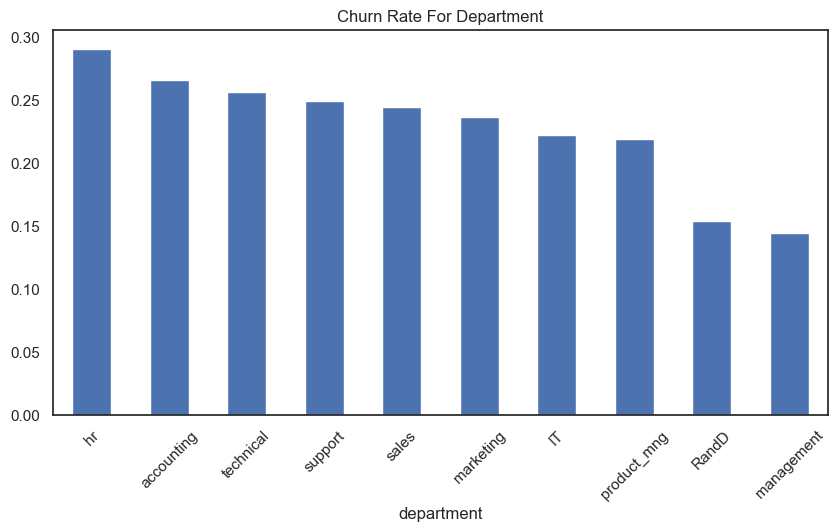

In [27]:
# Plot churn rate for department
data.groupby("department").churn.mean().sort_values(ascending=False).plot(kind="bar", title="Churn Rate For Department")
plt.xticks(rotation=45);

In [28]:
# Get department dimension
dep_dimension = data.department.value_counts()

# Get churn rate for department
churn_mean = data.groupby("department").churn.mean()

# Merge them
merged = pd.merge(dep_dimension, churn_mean, left_on = dep_dimension.index, right_on=churn_mean.index)
display(merged.head())

,key_0,department,churn
0,sales,4140,0.244928
1,technical,2720,0.256250
2,support,2229,0.248991
3,IT,1227,0.222494
4,product_mng,902,0.219512


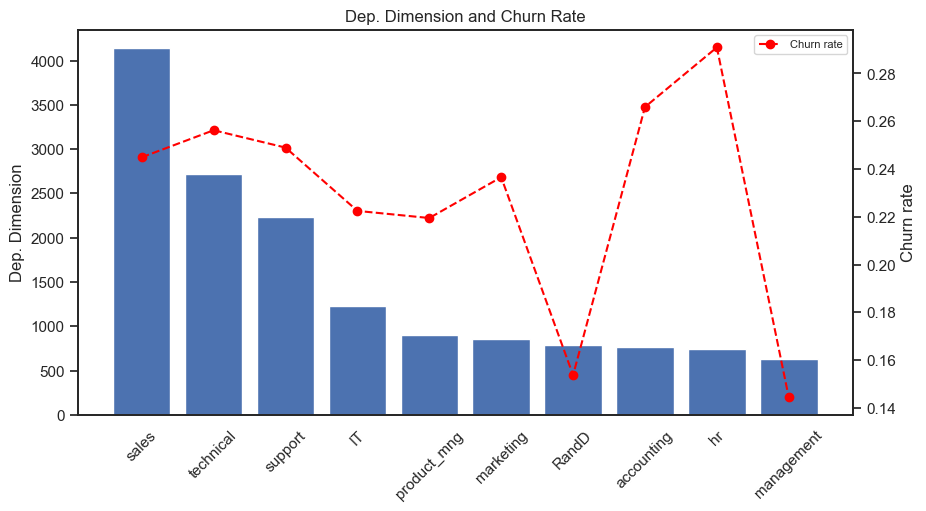

In [29]:
# Plot churn rate and dimension of the department
fig, ax = plt.subplots()
ax.bar(x = merged.key_0, height = merged.department)
ax.set_ylabel("Dep. Dimension")
ax.set_xticklabels(merged.key_0, rotation = 45)
ax2 = ax.twinx()
ax2.plot(merged.key_0, merged.churn, marker="o", linestyle="--", color="red")
ax2.set_ylabel("Churn rate")
plt.legend(["Churn rate"], loc="upper right", prop={'size': 8})
plt.title("Dep. Dimension and Churn Rate");

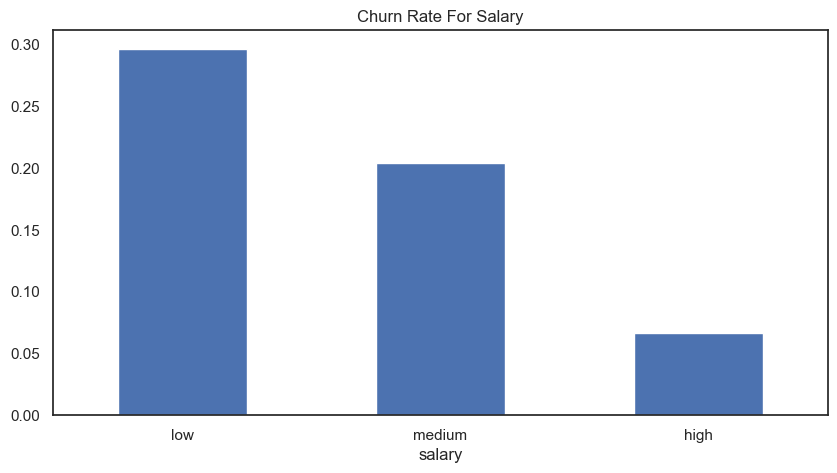

In [30]:
# Plot churn rate for salary category
data.groupby("salary").churn.mean().sort_values(ascending=False).plot(kind="bar", title="Churn Rate For Salary")
plt.xticks(rotation=360);

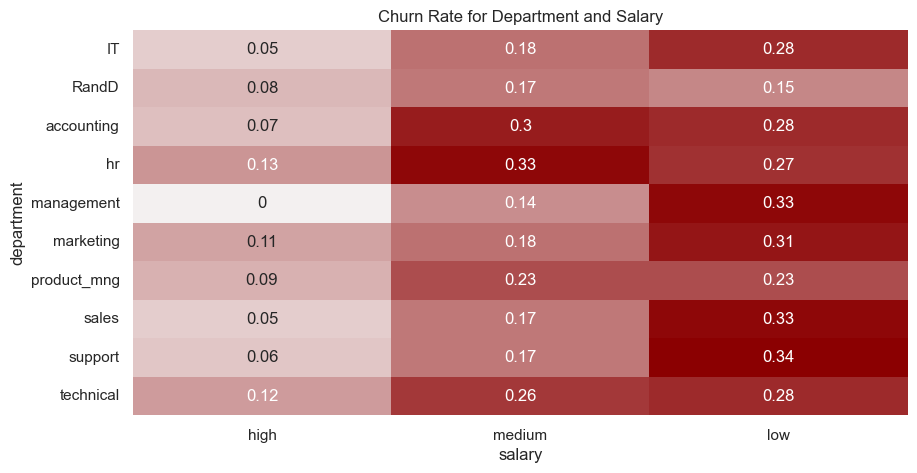

In [31]:
# Create a pivot table to show chrun rate for department and salary category
pivot = data.pivot_table(values="churn", index="department", columns="salary", aggfunc="mean").round(2)
pivot = pivot.reindex(columns=["high", "medium", "low"])

# Palette for heatmap
pal = sns.light_palette("#8B0001", as_cmap = True)

# Pivot table heatmap
sns.heatmap(pivot, cmap=pal, annot=True, cbar=False)
plt.title("Churn Rate for Department and Salary");

In [32]:
# Transform salary data type to ordinal categorical 
data["salary"] = data.salary.astype("category")
data["salary"] = data.salary.cat.reorder_categories(["low", "medium", "high"]).cat.codes

# See which code replaced each original category
pd.DataFrame({"Original" : ["low", "medium", "high"], "Encoded" : data.salary.unique()}).set_index("Original")


,Encoded
Original,
low,0
medium,1
high,2


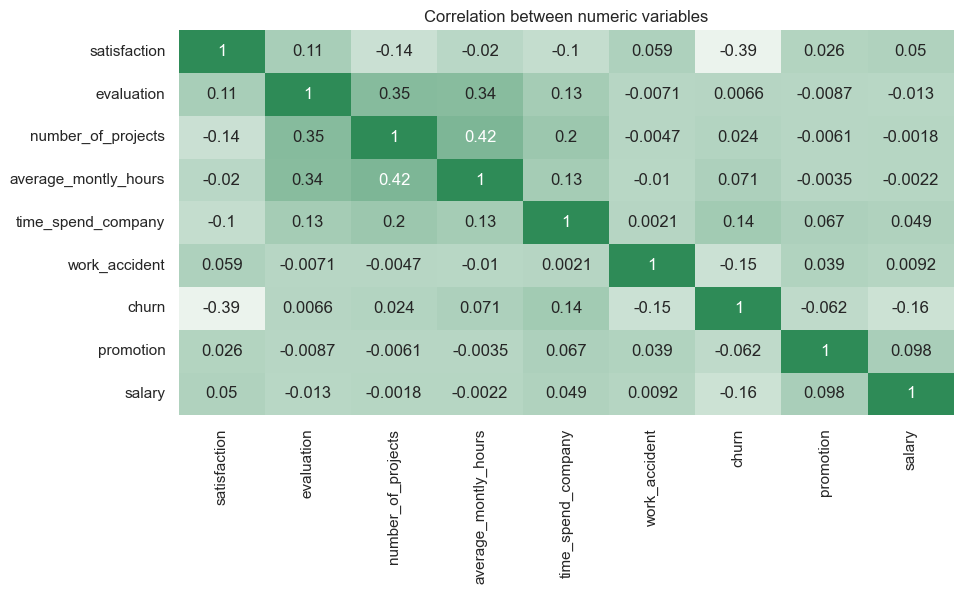

In [33]:
# Palette for heatmap
pal = sns.light_palette("Seagreen", as_cmap = True)

# Correlation heatmap
sns.heatmap(data.corr(), cmap=pal, annot=True, cbar=False)
plt.title("Correlation between numeric variables");

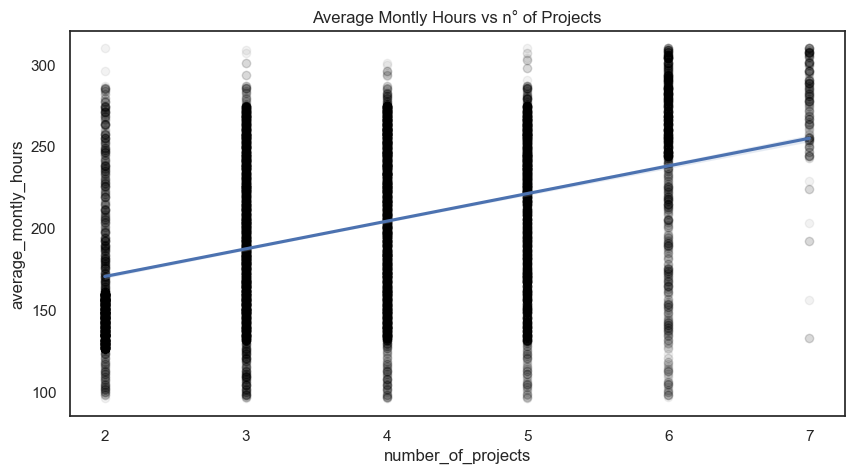

In [34]:
# Plot the 2 variables with the strongest correlation on a scatterplot with a regression line
sns.regplot(x="number_of_projects", y="average_montly_hours", data=data, 
            scatter_kws={"color":"black", "alpha": 0.05}).set(title = "Average Montly Hours vs n° of Projects");

In [35]:
# Get dummy variables for department
dummies = pd.get_dummies(data.department)

# Add dummies to original data
data = pd.concat([data, dummies], axis=1).drop("department", axis=1)

display(data.head())
display(data.shape)

,satisfaction,evaluation,number_of_projects,average_montly_hours,time_spend_company,work_accident,churn,promotion,salary,IT,RandD,accounting,hr,management,marketing,product_mng,sales,support,technical
0,0.38,0.53,2,157,3,0,1,0,0,0,0,0,0,0,0,0,1,0,0
1,0.80,0.86,5,262,6,0,1,0,1,0,0,0,0,0,0,0,1,0,0
2,0.11,0.88,7,272,4,0,1,0,1,0,0,0,0,0,0,0,1,0,0
3,0.72,0.87,5,223,5,0,1,0,0,0,0,0,0,0,0,0,1,0,0
4,0.37,0.52,2,159,3,0,1,0,0,0,0,0,0,0,0,0,1,0,0


(14999, 19)

## Model Development 

In [36]:
# Modules needed
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import plot_confusion_matrix, classification_report, roc_curve, roc_auc_score

In [53]:
# Define features (X) and target (y)
X = data.drop("churn", axis=1)
y = data.churn

In [38]:
# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [54]:
# Split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y , test_size=0.3, random_state=42)

# Initialize model
model = DecisionTreeClassifier()

# Fit model
model.fit(X_train, y_train)

# Get model accuracy for train and test data
print("Train accuracy:", round(model.score(X_train, y_train),2))
print("Test accuracy:", round(model.score(X_test, y_test),2))

# Get Decision Tree depth
print("Model depth:", model.get_depth())

Train accuracy: 1.0
Test accuracy: 0.97
Model depth: 21


## Model Evaluation Before Tuning

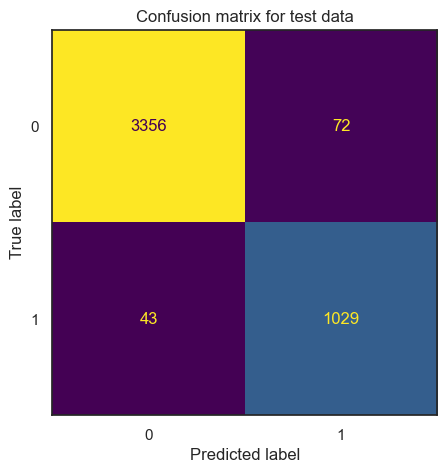

In [40]:
# Plot confusion matrix for test data
plot_confusion_matrix(model, X_test, y_test,colorbar=False)
plt.title("Confusion matrix for test data");

In [41]:
# Make a prediction with the model
y_pred = model.predict(X_test)

# Print classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.98      0.98      3428
           1       0.93      0.96      0.95      1072

    accuracy                           0.97      4500
   macro avg       0.96      0.97      0.97      4500
weighted avg       0.97      0.97      0.97      4500



Model performs 0.94 better than random choice


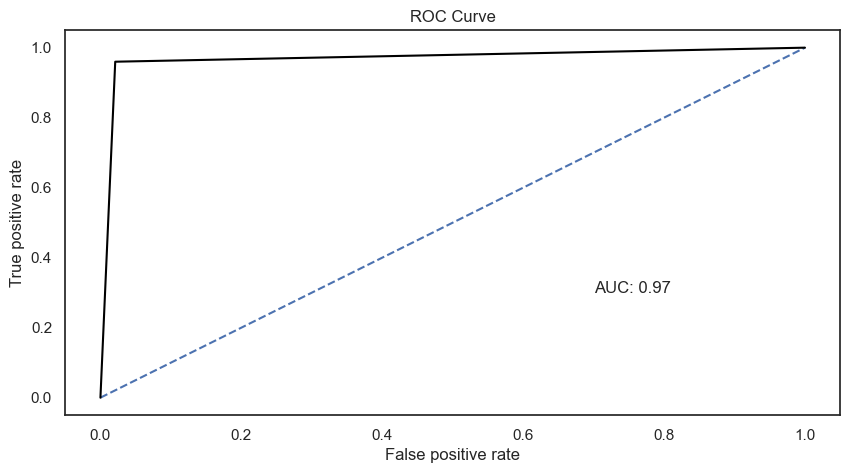

In [42]:
# Predict probabilities
y_pred_proba = model.predict_proba(X_test)[:,1]

# Plot the ROC curve with AUC score
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
AUC = round(roc_auc_score(y_test, y_pred_proba),2)
plt.plot([0,1], [0,1], "--")
plt.plot(fpr, tpr, color="black")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.annotate("AUC: " + str(AUC), xy = [0.7, 0.3])
plt.title("ROC Curve");

# Calculate how much the model perform better than random choice
print("Model performs {} better than random choice".format(AUC / 0.5 - 1))

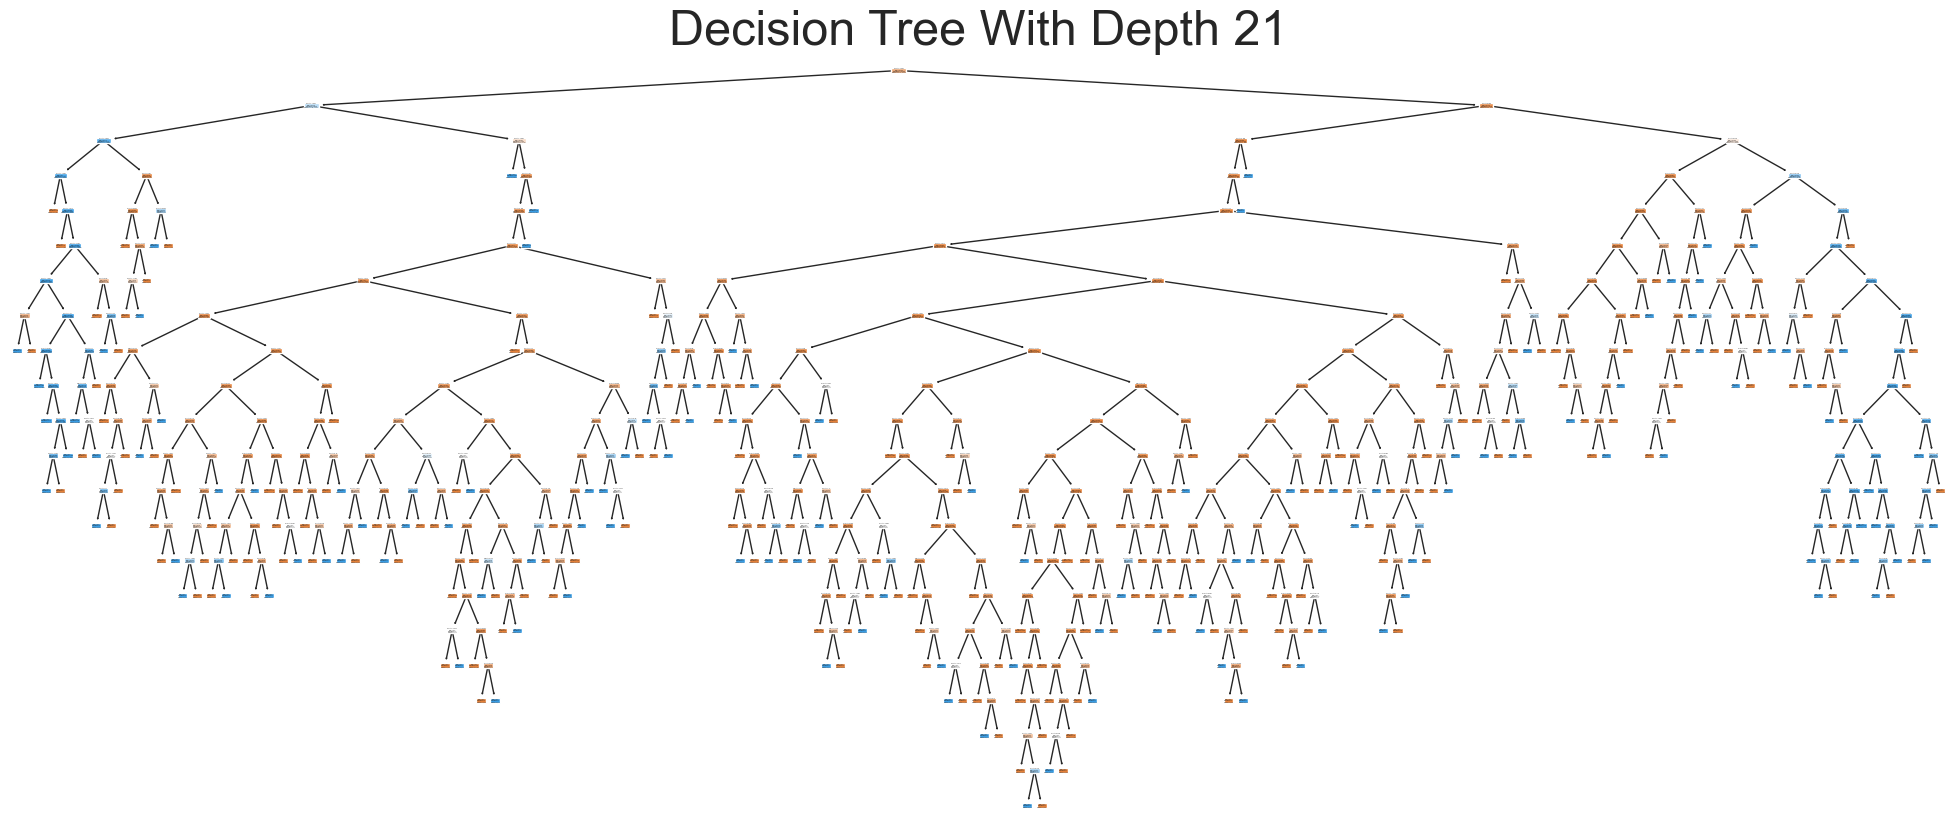

In [43]:
# Enlarge figure size
sns.set(rc={"figure.figsize":(25, 10)})

# Visualize the model
plot_tree(model, filled=True)
plt.title("Decision Tree With Depth {}".format(model.get_depth()), fontsize=35);

## Hyperparameters Tuning

In [44]:
# Define parameters to test
criteria = ["gini", "entropy"]
max_depths = np.arange(5, 21)
min_samples = np.arange(50, 550, 50)

# Create a dictionary
parameters = dict(criterion = criteria, max_depth=max_depths, min_samples_leaf = min_samples)

In [45]:
# Initialize the searcher with selected parameters and cross validation = 5
searcher = GridSearchCV(model, param_grid=parameters, scoring="accuracy", cv=5)

# Fit on X_train and y_train
searcher.fit(X_train, y_train)

# Display beat parameters and best score
display(searcher.best_params_)
display(searcher.best_score_)

{'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 50}

0.9685684793212186

In [46]:
# Initialize model with tuned hyperparameters
model_tuned = DecisionTreeClassifier(criterion = searcher.best_params_["criterion"],
                                    max_depth = searcher.best_params_["max_depth"],
                                    min_samples_leaf = searcher.best_params_["min_samples_leaf"])

# Fit model
model_tuned.fit(X_train, y_train)

# Get model accuracy for train and test data
print("Train accuracy:", round(model_tuned.score(X_train, y_train),2))
print("Test accuracy:", round(model_tuned.score(X_test, y_test),2))

# Get Decision Tree depth
print("Model depth:", model_tuned.get_depth())

Train accuracy: 0.97
Test accuracy: 0.96
Model depth: 5


## Model Evaluation After Tuning

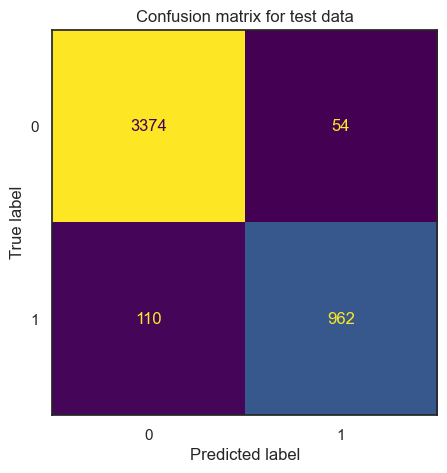

In [47]:
# Reduce figure size
sns.set(rc={"figure.figsize":(10, 5)})
sns.set_style("white")

# Plot confusion matrix for test data
plot_confusion_matrix(model_tuned, X_test, y_test,colorbar=False)
plt.title("Confusion matrix for test data");

In [48]:
# Make a prediction with the model
y_pred = model_tuned.predict(X_test)

# Print classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98      3428
           1       0.95      0.90      0.92      1072

    accuracy                           0.96      4500
   macro avg       0.96      0.94      0.95      4500
weighted avg       0.96      0.96      0.96      4500



Model performs 0.94 better than random choice


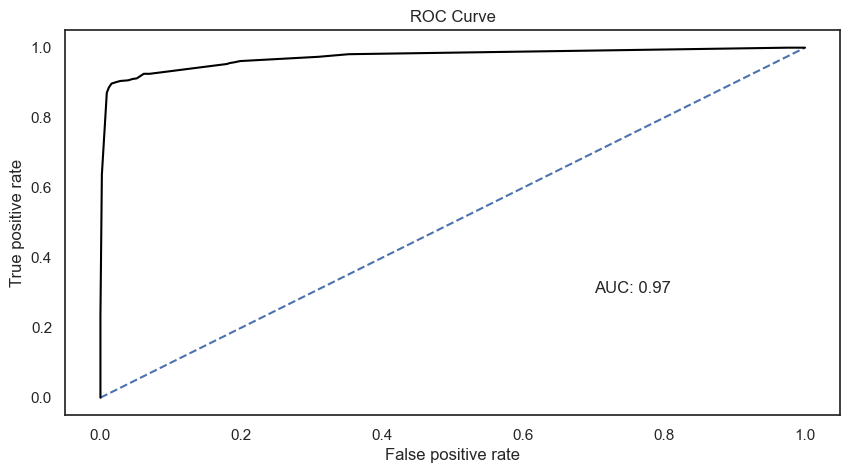

In [49]:
# Predict probabilities
y_pred_proba = model_tuned.predict_proba(X_test)[:,1]

# Plot the ROC curve with AUC score
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
AUC = round(roc_auc_score(y_test, y_pred_proba),2)
plt.plot([0,1], [0,1], "--")
plt.plot(fpr, tpr, color="black")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.annotate("AUC: " + str(AUC), xy = [0.7, 0.3])
plt.title("ROC Curve");

# Calculate how much the model perform better than random choice
print("Model performs {} better than random choice".format(AUC / 0.5 - 1))

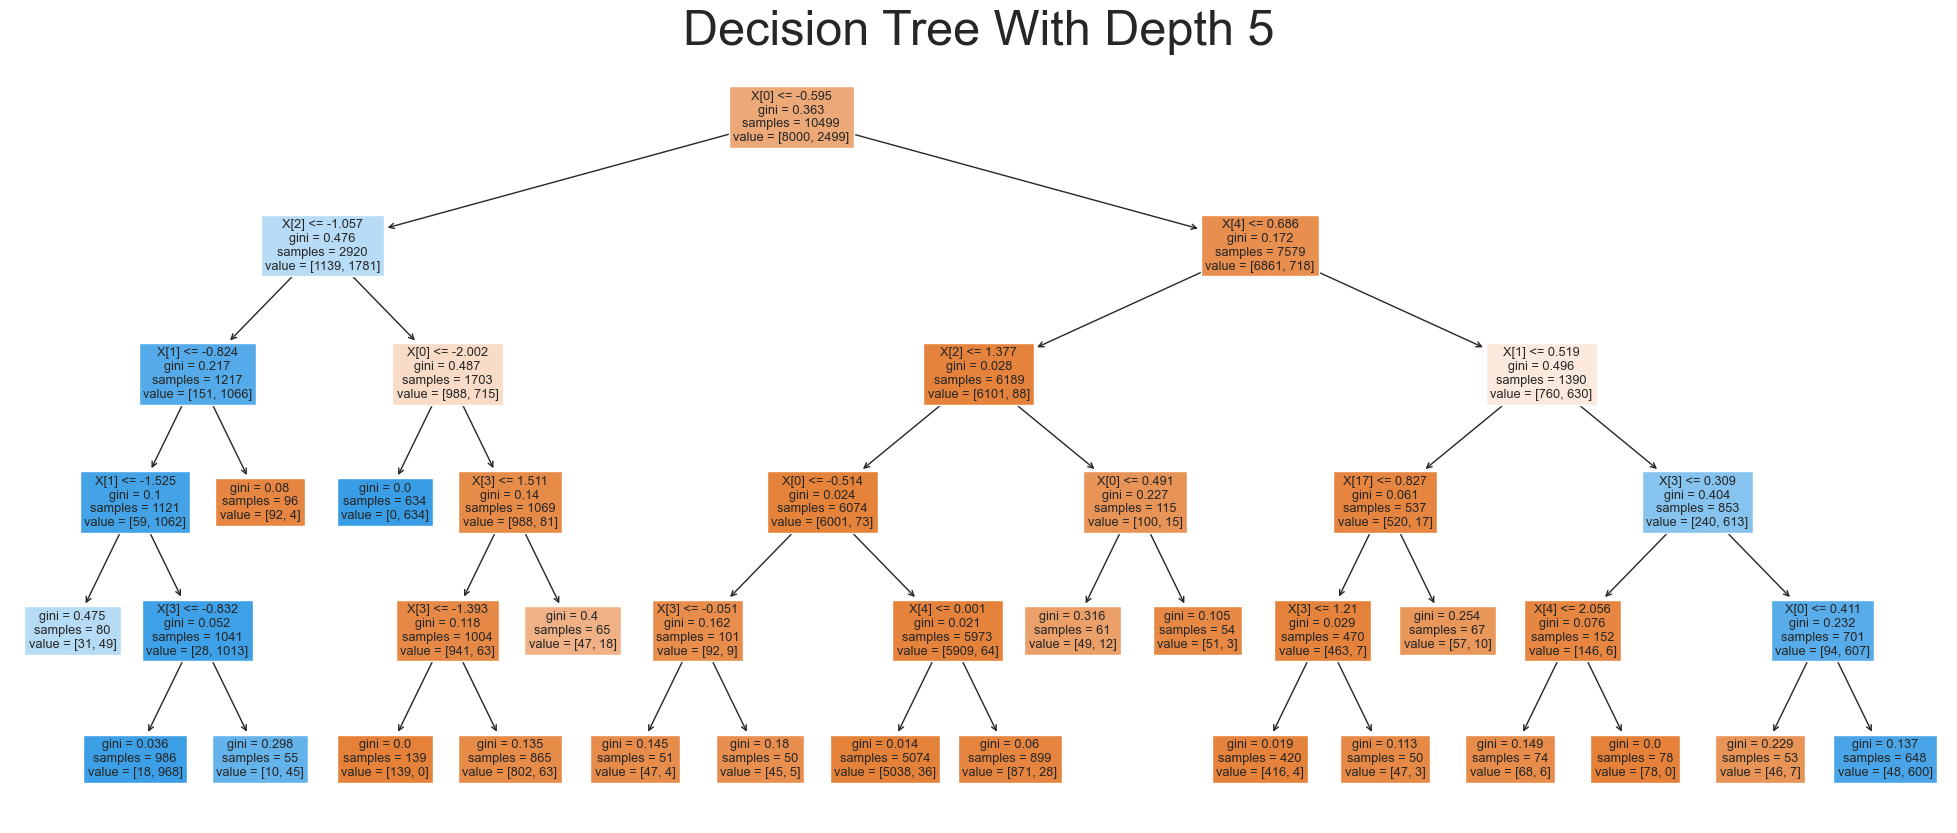

In [50]:
# Enlarge figure size
sns.set(rc={"figure.figsize":(25, 10)})

# Visualize the model
plot_tree(model_tuned, filled=True)
plt.title("Decision Tree With Depth {}".format(model_tuned.get_depth()), fontsize=35);